<a href="https://colab.research.google.com/github/szezlong/Titanic_Disaster_Analysis/blob/main/Titanic_DT_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praca domowa (5 punktów):
Dane do analizy Titanic:
 https://www.kaggle.com/c/titanic/overview

## Cel:
* Budowac model do przewidywania przeżycie pasażera.
* Znależć istotne atrybuty, które mają wpływ na decyzję modelu.

### Konfiguracja środowiska

In [24]:
import pandas as pd
import matplotlib.pyplot as plt


In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Dataset

In [6]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle competitions download -c titanic

!unzip "titanic.zip"

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 4.58MB/s]
Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [107]:
titanic_df = pd.read_csv('train.csv')

In [108]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Zadanie 1.
Wstępna analiza danych: liczba rekordów, liczba kolumn, rozkład decyzji. znaczenie kolumn. Czy są wartości nulowe?

#### Data Dictionary

|Variable|Definition|Key|
| --- | --- |:---|
| survival | Survival | 0 = No, 1 = Yes |
| pclass	| Ticket class	| 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex	| Sex | |
| Age | Age in years | |
| sibsp	| # of siblings / spouses aboard the Titanic | 	|
| parch	| # of parents / children aboard the Titanic | |
| ticket | Ticket number | |
| fare	| Passenger fare | 	|
| cabin	| Cabin number| 	|
| embarked | Port of Embarkation	| C = Cherbourg (France), Q = Queenstown (Ireland), S = Southampton (England) |

In [109]:
print(f"Liczba rekordów: {titanic_df.shape[0]}")
print(f"Liczba kolumn: {titanic_df.shape[1]}\n")

print(f"Rozkład decyzji (przeżycie):\n{titanic_df['Survived'].value_counts()}\n")

print(f"Znaczenie kolumn:\n{titanic_df.describe()}\n")

print(f"Wartości nullowe:\n{titanic_df.isnull().sum()}")

Liczba rekordów: 891
Liczba kolumn: 12

Rozkład decyzji (przeżycie):
Survived
0    549
1    342
Name: count, dtype: int64

Znaczenie kolumn:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75% 

####Czyszczenie danych i inżynieria cech


*   Atrybut Embarkment points został przekształcony na boolean.
* Atrybut Sex został przekształcony na boolean (is_male = 1).
* Uzupełniono wartości nullowe dla atrybutu age: NaN = 100.
*   Ponieważ atrybut Cabin jest nullowy dla 77% rekordów, zamieniono tę kolumnę na atrybut has_cabin, świadczący o tym, czy rekord zawiera informację o numerze kabiny



In [110]:
# Embarkment booleans
for k in titanic_df.Embarked.unique():
    if type(k)==str:
        titanic_df['emb_' + k] = (titanic_df.Embarked==k)*1

# Sex boolean
titanic_df['is_male'] = (titanic_df.Sex=='male')*1

# Has cabin boolean
titanic_df.loc[:, 'has_cabin'] = 1
titanic_df.loc[titanic_df.Cabin.isna(), 'has_cabin'] = 0

# Age fill
titanic_df.loc[titanic_df.Age.isna(), 'Age'] = 100

titanic_df = titanic_df.drop(['Cabin', 'Embarked'], axis=1)
print(list(titanic_df))
titanic_df.head()

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'emb_S', 'emb_C', 'emb_Q', 'is_male', 'has_cabin']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,emb_S,emb_C,emb_Q,is_male,has_cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,1,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,0,1,0,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,1,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,1,0,0,1,0


In [111]:
print(f"Wartości nullowe:\n{titanic_df.isnull().sum()}")

Wartości nullowe:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
emb_S          0
emb_C          0
emb_Q          0
is_male        0
has_cabin      0
dtype: int64


Text(0.5, 1.0, 'Survival by age')

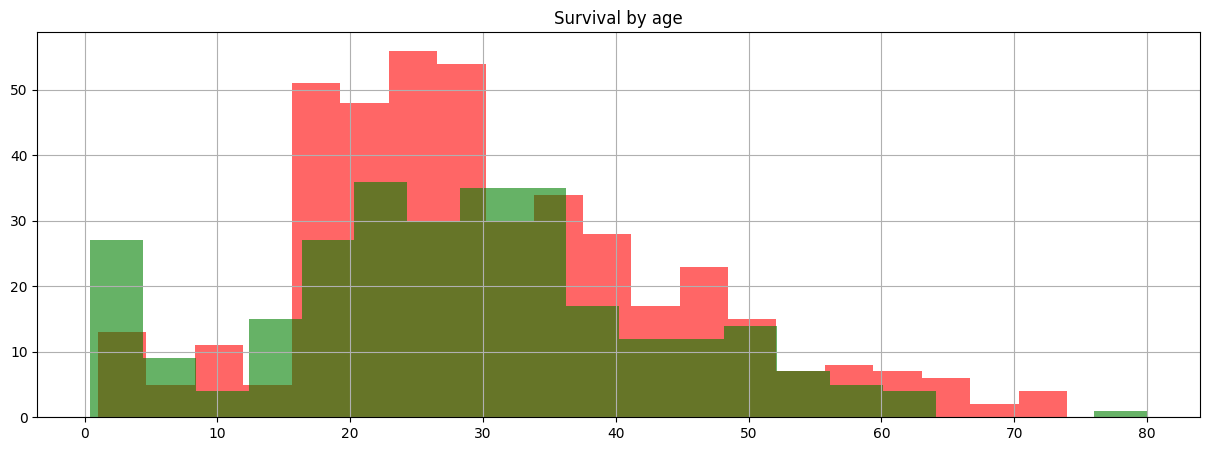

In [112]:
titanic_df.loc[(titanic_df.Survived==0) & (titanic_df.Age != 100), 'Age'].hist(bins=20, alpha=.6, color='red', figsize=[15, 5])
titanic_df.loc[(titanic_df.Survived==1) & (titanic_df.Age != 100), 'Age'].hist(bins=20, alpha=.6, color='green')
plt.title('Survival by age')

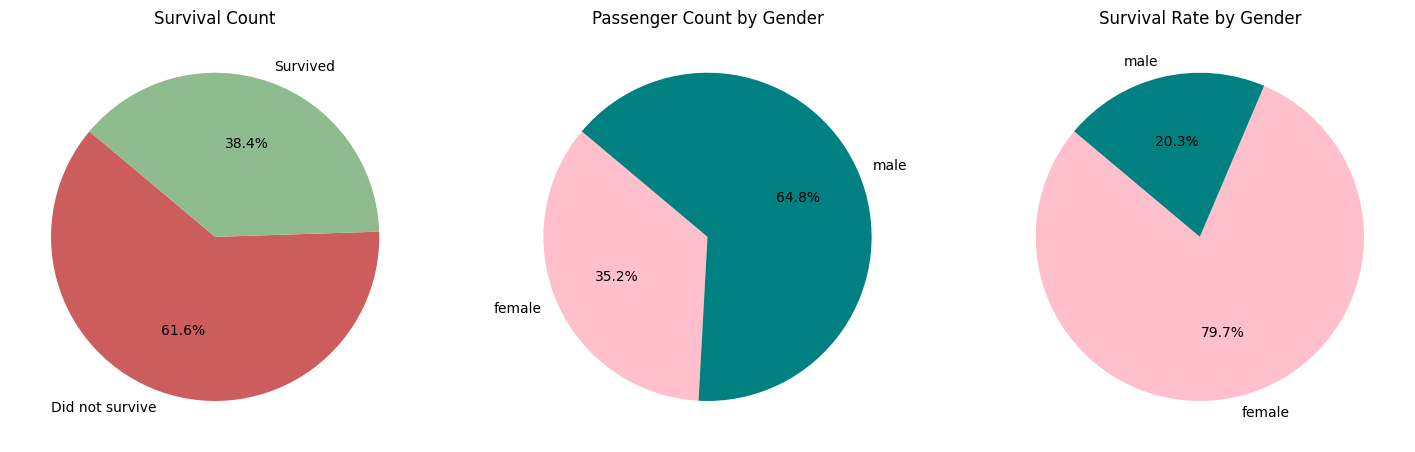

In [113]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].pie(titanic_df['Survived'].value_counts(), labels=['Did not survive', 'Survived'], autopct='%1.1f%%', startangle=140, colors=['indianred', 'darkseagreen'])
axes[0].set_title('Survival Count')

axes[1].pie(titanic_df['Sex'].value_counts()[::-1], labels=titanic_df['Sex'].value_counts().index[::-1], autopct='%1.1f%%', startangle=140, colors=['pink', 'teal'])
axes[1].set_title('Passenger Count by Gender')

survival_rate_by_gender = titanic_df[['Sex', 'Survived']].groupby('Sex').agg(['mean', 'count'])
axes[2].pie(survival_rate_by_gender['Survived']['mean'], labels=survival_rate_by_gender['Survived']['mean'].index, autopct='%1.1f%%', startangle=140, colors=['pink', 'teal'], normalize=True)
axes[2].set_title('Survival Rate by Gender')

plt.show()

## Zadanie 2:
Trenować drzewo decyzyjne, ustawić parametry, żeby maksymalizować *trafność modelu* (*accuracy*)  
## Zadanie 3:
Trenować wybrany ensemble model, żeby maksymalizować *trafność* .
## Zadanie 4:  
Podać, które atrybuty są istotne (analizując random forest)
Wkazówka: atrybuty znajdują się blisko korzenia są ważniejsze niż te, które znajdują się daleko korzenia.